## CUSTOMIZATION
---

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()
# подключить GPU: Runtime -> Change runtime type -> Hardware accelerator: GPU
# вывод: '/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# монтируем гугл диск

In [0]:
# ! cp /content/gdrive/'My Drive'/Segmentation/dataset.zip .
# ! unzip -q dataset.zip
# ! rm dataset.zip
! cp /content/gdrive/'My Drive'/Segmentation/dataset_512x512.zip .
! unzip -q dataset_512x512.zip
! rm dataset_512x512.zip
# ! cp /content/gdrive/'My Drive'/Segmentation/public_test.zip .
# ! unzip -q public_test.zip
# ! rm public_test.zip
# копируем и разархивируем файлы в colab
! ls

---

## SEGMENTATION
---

### import

In [0]:
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Model, save_model, load_model
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                          UpSampling2D, Conv2DTranspose, ZeroPadding2D,
                          concatenate)
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, CSVLogger
import matplotlib.pyplot as plt
import numpy as np
from os.path import join

### global

In [0]:
N_EXPERIMENT = 2

MODEL_NAME = f'{N_EXPERIMENT}_segmentation_model'
WEIGHT_NAME = f'{N_EXPERIMENT}_segmentation_weight'
LOG_NAME = f'{N_EXPERIMENT}_training_log.csv'
GDRIVE_PATH = f'./gdrive/My Drive/Segmentation/{N_EXPERIMENT}'
CHECKPOINT_PATH = f'{GDRIVE_PATH}/{WEIGHT_NAME}''_{epoch:03d}_iou-{iou:.3f}_valiou-{val_iou:.3f}.h5'
DATA_PATH = './dataset_512x512'

IMAGE_SIZE = (512, 512, 3)
RANDOM_SEED = 13
BATCH_SIZE = 8

### generator

#### ImageDataGenerator

In [0]:
def get_generators_from_directory(dirname=DATA_PATH):
    train_datagen_args = dict(
        rescale=1/255.,  # [0..1]
        rotation_range=35,
        width_shift_range=0.15,
        height_shift_range=0.15,
        zoom_range=0.15,
        fill_mode='constant',
        cval=0.0,
        horizontal_flip=True,
        # preprocessing_function=preprocess_input,  # [-1..1], отрицательный loss(
        dtype=np.float32
    )
    valid_datagen_args = dict(
        rescale=1/255.,
        # preprocessing_function=preprocess_input,
        dtype=np.float32
    )
    flow_args = dict(
        target_size=IMAGE_SIZE[:2],
        class_mode=None,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=RANDOM_SEED
    )

    train_img_datagen = ImageDataGenerator(**train_datagen_args)
    train_img_datagen = train_img_datagen.flow_from_directory(
        directory=join(dirname, 'train/images'),
        color_mode='rgb',
        **flow_args
    )
    train_gt_datagen = ImageDataGenerator(**train_datagen_args)
    train_gt_datagen = train_gt_datagen.flow_from_directory(
        directory=join(dirname, 'train/gt'),
        color_mode='grayscale',
        **flow_args
    )
    train_generator = zip(train_img_datagen, train_gt_datagen)

    valid_img_datagen = ImageDataGenerator(**valid_datagen_args)
    valid_img_datagen = valid_img_datagen.flow_from_directory(
        directory=join(dirname, 'valid/images'),
        color_mode='rgb',
        **flow_args
    )
    valid_gt_datagen = ImageDataGenerator(**valid_datagen_args)
    valid_gt_datagen = valid_gt_datagen.flow_from_directory(
        directory=join(dirname, 'valid/gt'),
        color_mode='grayscale',
        **flow_args
    )
    valid_generator = zip(valid_img_datagen, valid_gt_datagen)

    return train_generator, valid_generator

In [10]:
# GENERATORS
train_generator, valid_generator = get_generators_from_directory()

Found 9788 images belonging to 200 classes.
Found 9788 images belonging to 200 classes.
Found 2000 images belonging to 200 classes.
Found 2000 images belonging to 200 classes.


#### DataGen

In [0]:
from albumentations import (ShiftScaleRotate, Compose, Blur)
import itertools
import random
import math
import glob
import os

class DataGen(object):
    def __init__(self, dir_name, target_size, shuffle=True, transform=True):
        self.target_size = target_size[:2]
        self.transform = transform
        self.dir_name = dir_name
        self.img_paths = [file_path for class_name in glob.glob(os.path.join(dir_name, 'images/*'))
                          for file_path in glob.glob(os.path.join(class_name, '*.jpg'))]
        if shuffle: random.shuffle(self.img_paths)
        self.gt_paths = [path.replace('images', 'gt').replace('.jpg', '.png')
                         for path in self.img_paths]
        self.data_paths = zip(self.img_paths, self.gt_paths)

    def generate_data(self):
        for img_path, gt_path in itertools.cycle(self.data_paths):
            X = img_to_array(load_img(img_path, color_mode='rgb')) / 255.
            # X = X / 127.5 - 1
            ud_border = (self.target_size[0] - X.shape[0]) / 2
            lr_border = (self.target_size[1] - X.shape[1]) / 2
            X = np.pad(X, ((math.floor(ud_border), math.ceil(ud_border)),
                           (math.floor(lr_border), math.ceil(lr_border)), (0, 0)),
                       mode='constant')
            y = img_to_array(load_img(gt_path, color_mode='grayscale'))
            y = np.pad(y, ((math.floor(ud_border), math.ceil(ud_border)),
                           (math.floor(lr_border), math.ceil(lr_border)), (0, 0)),
                       mode='constant')         
            yield (X, y)

    def create_transformer(self, image, mask):
        return Compose([ShiftScaleRotate(shift_limit=0.15,
                                         scale_limit=0.15,
                                         rotate_limit=35,
                                         interpolation=1,
                                         border_mode=0,
                                         p=0.5),
                        Blur(blur_limit=3, p=0.2)],
                       p=0.5
                       )(image=image, mask=mask)

    def flow_from_directory(self, batch_size=1):
        X_batch = np.empty((batch_size, *self.target_size, 3))
        y_batch = np.empty((batch_size, *self.target_size, 1))
        data = self.generate_data()

        while True:
            for i in range(batch_size):
                X, y = next(data)
                if self.transform:
                    transformed = self.create_transformer(X, y)
                    X, y = transformed['image'], np.array(transformed['mask'])
                X_batch[i, ...], y_batch[i, ...] = X, y

            yield (X_batch, y_batch)

In [0]:
# GENERATORS
train_datagen = DataGen(dir_name=os.path.join(DATA_PATH, 'train'),
                        target_size=IMAGE_SIZE[:2])
train_generator = train_datagen.flow_from_directory(batch_size=BATCH_SIZE)
valid_datagen = DataGen(dir_name=os.path.join(DATA_PATH, 'valid'),
                        target_size=IMAGE_SIZE[:2])
valid_generator = valid_datagen.flow_from_directory(batch_size=BATCH_SIZE)

In [0]:
# CHECK
img, gt = next(train_generator)
visualize(img, gt, prediction=False)

### model

#### metric: IoU

In [0]:
def iou(y_true, y_pred):
    p = K.cast((y_pred > 0.5), dtype='float32')
    return K.mean(K.sum(K.clip(y_true * p, 0, 1), axis=(1, 2, 3)) /
                  (K.sum(K.clip(y_true + p,  0, 1), axis=(1, 2, 3))))

#### U-net

In [0]:
def U_net(start_neurons=64, lr=5e-5, l2=1e-4, skip_connection=True):
    input_layer = Input(IMAGE_SIZE)
    # kernel_regularizer=regularizers.l2(l2) ???

    # ENCODER
    conv1 = Conv2D(filters=start_neurons*1, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(input_layer)
    conv1 = Conv2D(filters=start_neurons*1, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filters=start_neurons*2, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(pool1)
    conv2 = Conv2D(filters=start_neurons*2, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(filters=start_neurons*4, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(pool2)
    conv3 = Conv2D(filters=start_neurons*4, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(filters=start_neurons*8, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(pool3)
    conv4 = Conv2D(filters=start_neurons*8, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # MIDDLE
    convm = Conv2D(filters=start_neurons*16, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(pool4)
    convm = Conv2D(filters=start_neurons*16, kernel_size=(3, 3), activation="relu",
                   padding="same", kernel_initializer="he_normal")(convm)

    # DECODER
    deconv4 = Conv2DTranspose(filters=start_neurons*8, kernel_size=(3, 3),
                              strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(filters=start_neurons*8, kernel_size=(3, 3), activation="relu",
                    padding="same", kernel_initializer="he_normal")(uconv4)
    uconv4 = Conv2D(filters=start_neurons*8, kernel_size=(3, 3), activation="relu",
                    padding="same", kernel_initializer="he_normal")(uconv4)

    deconv3 = Conv2DTranspose(filters=start_neurons*4, kernel_size=(3, 3),
                              strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(filters=start_neurons*4, kernel_size=(3, 3), activation="relu",
                    padding="same", kernel_initializer="he_normal")(uconv3)
    uconv3 = Conv2D(filters=start_neurons*4, kernel_size=(3, 3), activation="relu",
                    padding="same", kernel_initializer="he_normal")(uconv3)

    deconv2 = Conv2DTranspose(filters=start_neurons*2, kernel_size=(3, 3),
                              strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(filters=start_neurons*2, kernel_size=(3, 3), activation="relu",
                    padding="same", kernel_initializer="he_normal")(uconv2)
    uconv2 = Conv2D(filters=start_neurons*2, kernel_size=(3, 3), activation="relu",
                    padding="same", kernel_initializer="he_normal")(uconv2)

    deconv1 = Conv2DTranspose(filters=start_neurons*1, kernel_size=(3, 3),
                              strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(filters=start_neurons*1, kernel_size=(3, 3), activation="relu",
                    padding="same", kernel_initializer="he_normal")(uconv1)
    uconv1 = Conv2D(filters=start_neurons*1, kernel_size=(3, 3), activation="relu",
                    padding="same", kernel_initializer="he_normal")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(filters=1, kernel_size=(1,1), padding="same", activation="sigmoid")(uconv1)

    encoder_decoder = Model(inputs=input_layer,
                            outputs=output_layer,
                            name="U-net")
    encoder_decoder.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[iou])

    return encoder_decoder

#### My model: ResNet50_v2

In [0]:
def get_encoder_decoder_model(l2=1e-4, resnet_weights='imagenet',
                              skip_connection=True, encoder_trainable=True):
    resnet_model = ResNet50V2(include_top=False, weights=resnet_weights,
                              input_shape=IMAGE_SIZE)
    # ENCODER
    encoder = Model(inputs=resnet_model.input,
                    outputs=resnet_model.layers[160].output, # 155, 158, 160
                    name="encoder")

    # DECODER
    # 155
    deconv1 = encoder.output
    # deconv1 = ZeroPadding2D(padding=(1, 1))(deconv1)
    # deconv1 = Conv2D(filters=512, kernel_size=(3, 3), activation="relu",
    #                  kernel_initializer="he_normal")(deconv1)
    # deconv1 = BatchNormalization()(deconv1)

    deconv2 = UpSampling2D(size=(2, 2))(deconv1)
    if skip_connection:
        deconv2 = concatenate([encoder.layers[84].output, deconv2], axis=3)
    deconv2 = ZeroPadding2D(padding=(1, 1))(deconv2)
    deconv2 = Conv2D(filters=256, kernel_size=(3, 3), activation="relu",
                     kernel_initializer="he_normal")(deconv2)
    deconv2 = BatchNormalization()(deconv2)

    deconv3 = UpSampling2D(size=(2, 2))(deconv2)
    if skip_connection:
        deconv3 = concatenate([encoder.layers[38].output, deconv3], axis=3)
    deconv3 = ZeroPadding2D(padding=(1, 1))(deconv3)
    deconv3 = Conv2D(filters=128, kernel_size=(3, 3), activation="relu",
                     kernel_initializer="he_normal")(deconv3)
    deconv3 = BatchNormalization()(deconv3)

    deconv4 = UpSampling2D(size=(2, 2))(deconv3)
    if skip_connection:
        deconv4 = concatenate([encoder.layers[15].output, deconv4], axis=3)
    deconv4 = ZeroPadding2D(padding=(1, 1))(deconv4)
    deconv4 = Conv2D(filters=64, kernel_size=(3, 3), activation="relu",
                     kernel_initializer="he_normal")(deconv4)
    deconv4 = BatchNormalization()(deconv4)

    deconv5 = UpSampling2D(size=(2, 2))(deconv4)
    if skip_connection:
        deconv5 = concatenate([encoder.layers[2].output, deconv5], axis=3)
    deconv5 = ZeroPadding2D(padding=(1, 1))(deconv5)
    deconv5 = Conv2D(filters=64, kernel_size=(3, 3), activation="relu",
                     kernel_initializer="he_normal")(deconv5)
    deconv5 = BatchNormalization()(deconv5)

    deconv6 = UpSampling2D(size=(2, 2))(deconv5)
    deconv6 = ZeroPadding2D(padding=(1, 1))(deconv6)
    deconv6 = Conv2D(filters=64, kernel_size=(3, 3), activation="relu",
                     kernel_initializer="he_normal")(deconv6)
    deconv6 = BatchNormalization()(deconv6)

    output_layer = Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid",
                          padding='same')(deconv6)

    encoder_decoder = Model(inputs=encoder.input,
                            outputs=output_layer,
                            name='encoder_decoder')
    if not encoder_trainable:
        for i, layer in enumerate(encoder_decoder.layers[:161]):
            layer.trainable = False

    return encoder_decoder

### fit

In [0]:
# CALLBACKS
checkpointer = ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_iou',
                               verbose=1, save_best_only=True,
                               save_weights_only=True, mode='max')
logger = CSVLogger(LOG_NAME)

In [0]:
model = get_encoder_decoder_model(encoder_trainable=False)
model.compile(optimizer=Adam(lr=1e-4),
              loss='binary_crossentropy',
              metrics = [iou])
# plot_model(model, show_shapes=True, rankdir='LR')
# model.summary()

In [0]:
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=9788 // BATCH_SIZE,
    epochs=10,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=2000 // BATCH_SIZE,
    callbacks=[logger, checkpointer],
    shuffle=True,
    initial_epoch=0
)

In [0]:
# TRAINABLE
model = get_encoder_decoder_model()
model.load_weights('2_segmentation_weight_003_iou-0.779_valiou-0.740.h5')
model.compile(optimizer=Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics = [iou])
model.summary()

In [0]:
# CONTINUE...
logger = CSVLogger(LOG_NAME, append=True)
model.fit_generator(
    generator=train_generator,
    steps_per_epoch=9788 // BATCH_SIZE,
    epochs=15,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=2000 // BATCH_SIZE,
    callbacks=[logger, checkpointer],
    shuffle=True,
    initial_epoch=10
)

### Recompile

In [0]:
re_model = get_encoder_decoder_model()
re_model.load_weights('segmentation_weight.h5')
re_model.compile(optimizer='adam', loss='binary_crossentropy')
save_model(re_model, 'RE_segmentation_model.hdf5')

or

In [0]:
re_model = load_model('segmentation_model.hdf5', custom_objects={'iou': iou})
re_model.compile(optimizer='adam', loss='binary_crossentropy')
save_model(re_model, 'RE_segmentation_model.hdf5')

#### Load model

In [0]:
l_model = load_model('RE_segmentation_model.hdf5')

### Visualize

In [0]:
def visualize(X, gt=None, prediction=True, model=None,
              apply_mask=False, output_range=10):
    gridsize = (1, 4)
    for i in range(min(output_range, X.shape[0])):
        img =  X[i]
        if X[i].min() < 0:
            img = (img + 1) / 2
        fig = plt.figure(figsize=(15, 4))
        ax1 = plt.subplot2grid(gridsize, (0, 0))
        ax1.imshow(img)
        ax1.set_title('Original image')
        ax1.set_xticks([])
        ax1.set_yticks([]) 
        if gt is not None:
            ax2 = plt.subplot2grid(gridsize, (0, 1))
            ax2.imshow(np.squeeze(gt[i]), cmap='gray')
            ax2.set_title('Mask')
            ax2.set_xticks([])
            ax2.set_yticks([])
        if prediction and model is not None:
            pred = model.predict(X[i][np.newaxis, ...])
            pred = (pred > 0.5).astype(np.uint8)
            ax3 = plt.subplot2grid(gridsize, (0, 2))
            ax3.imshow(np.squeeze(pred), cmap='gray')
            ax3.set_title('Prediction')
            ax3.set_xticks([])
            ax3.set_yticks([])
            if apply_mask:
                ax4 = plt.subplot2grid(gridsize, (0, 3))
                ax4.imshow(img, alpha=0.1)
                ax4.set_title('Apply mask')
                ax4.set_xticks([])
                ax4.set_yticks([])
        plt.show()
        plt.close()

In [0]:
X, y = next(valid_generator)

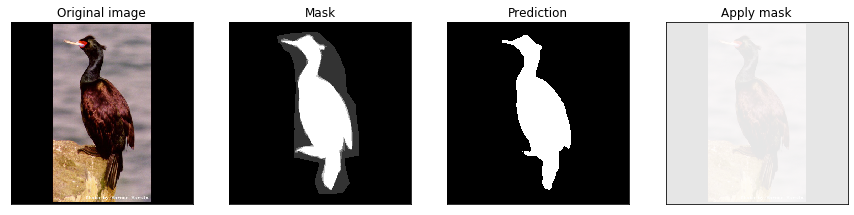

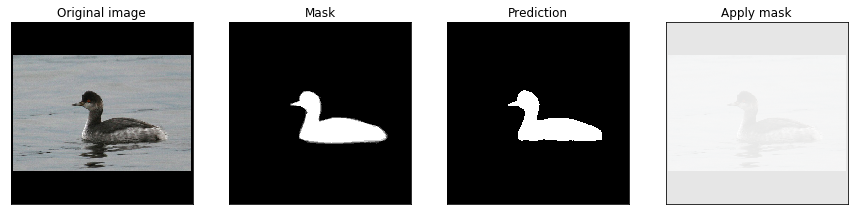

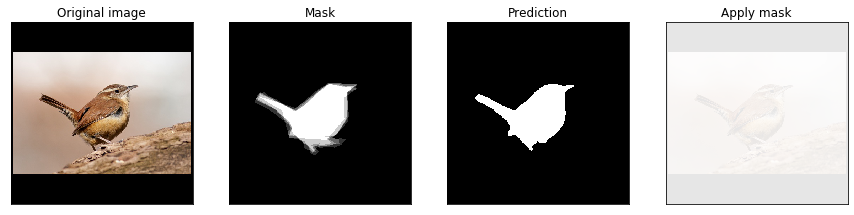

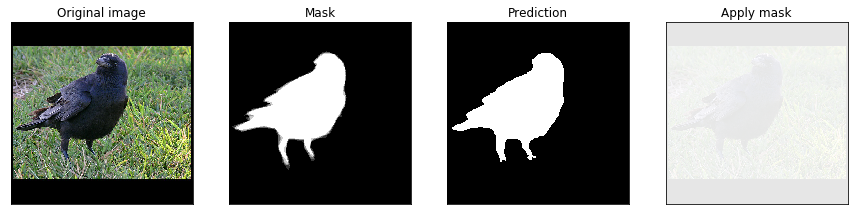

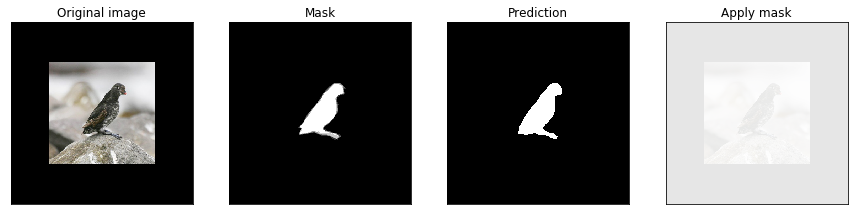

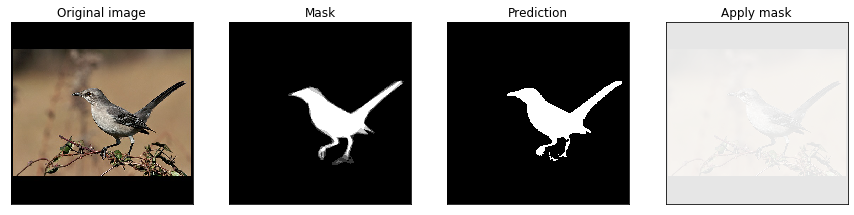

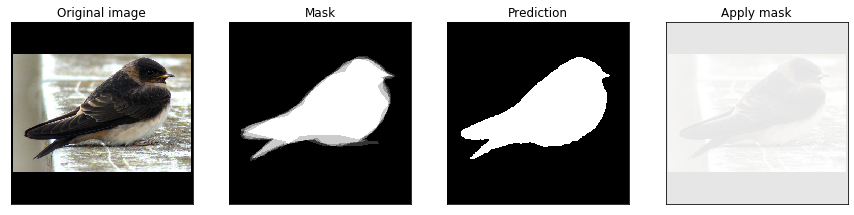

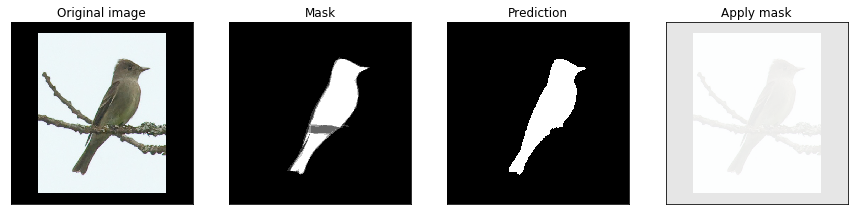

In [24]:
visualize(X, y, model=l_model, apply_mask=True)